In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.utils.data import generate_data, evaluate_print

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("df_short.csv")
data.head()

,order_date,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,discounted_price,...,product_id,product_name,brand_id,brand_name,gender_id,gender_name,category_id,category_name,attributet_name,attribute_value
0,2021-06-16 12:44:38.457000+00:00,52051117,0,968,1021208780,662568159,4629415,17667968,79.99,67.99,...,3855990,Siyah Basic Kolsuz Elbise TWOSS19FG0063,40,TRENDYOLMİLLA,4295.0,Kadın / Kız,1182,Elbise,BEDEN,34
1,2021-07-11 17:22:20.378000+00:00,8299536,1,63,1075078353,702671195,45606939,80444942,149.99,149.99,...,38284842,Gri Gömlek 020579-30207,18,Mavi,4294.0,Erkek,597,Gömlek,BEDEN,S
2,2021-06-29 22:43:06.607000+00:00,30397754,0,968,1050545426,688242993,37575006,66761566,39.99,33.99,...,31455345,Gül Kurusu Vatkalı Basic Örme T-Shirt TWOSS20T...,40,TRENDYOLMİLLA,4295.0,Kadın / Kız,604,T-Shirt,BEDEN,L
3,2021-06-13 01:46:16.626000+00:00,67361210,0,968,1013647347,658333339,83310060,140370830,99.99,99.99,...,71701550,Fuşya Wide Leg Pantolon TWOSS21PL0305,40,TRENDYOLMİLLA,4295.0,Kadın / Kız,529,Pantolon,BEDEN,38
4,2021-07-19 23:01:45.708000+00:00,16112109,0,2454,1089406617,711251385,46054397,81081000,899.99,629.99,...,37985915,Mavi Keten Pantolon Ceket Takım,8145,Setre,4295.0,Kadın / Kız,2160,Alt-Üst Takım,BEDEN,S


In [3]:
df = data.sample(n=10000, random_state=0)

In [4]:
df["ship_cost"] = df["ship_cost"].fillna(df["ship_cost"].mean())

In [5]:
drop_cols = ["order_date", "user_id", "supplier_id", "order_line_item_id", "order_parent_id",
             "product_content_id", "product_variant_id", "coupon_id", "promotion_name",
            "is_wallet_trx", "is_saved_card_trx", "discounted_price", "promotion_award_value", 
             "coupon_discount", "product_name", "brand_name", "gender_name", "category_name", 
             "attributet_name", "attribute_value", "order_line_item_id", "gender_id", "brand_id", "category_id"]

In [6]:
#drop_cols = ["order_date", "coupon_id", "coupon_discount", "gender_id", "promotion_award_value"]

In [7]:
X_train = df.drop(drop_cols, axis=1)
y_train = df["is_returned"]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=0)

In [9]:
# train kNN detector
from pyod.models.knn import KNN
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [10]:
# If you want to see the predictions of the training data, you can use this way:
y_train_scores = clf.decision_scores_
y_train_scores

array([2.59197581e+04, 7.29150043e+04, 4.30420003e+04, ...,
       1.32571858e+04, 1.52491483e+04, 1.89939397e+00])

In [11]:
# Now we have the trained K-NN model, let's apply to the test data to get the predictions
y_test_pred = clf.predict(X_test) # outlier labels (0 or 1)
y_test_pred 

array([0, 1, 0, ..., 0, 1, 0])

In [12]:
# Because it is '0' and '1', we can run a count statistic. There are 44 '1's and 456 '0's. The number of anomalies is roughly ten percent, as we have generated before:
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))

{0: 1816, 1: 184}

In [13]:
# And you can generate the anomaly score using clf.decision_function:
y_test_scores = clf.decision_function(X_test)
y_test_scores

array([6.60662312e+04, 1.65508148e+05, 7.15262271e+01, ...,
       1.88679732e+01, 1.57761911e+05, 7.80620816e+01])

In [14]:
# Let's see how many '0's and '1's. We get 452 '0's and 48 '1's.
df_test = pd.DataFrame(X_test)
df_test['score'] = y_test_scores

In [15]:
df_test['score']

892       66066.231187
52705    165508.147757
11491        71.526227
7484          0.528066
89424        39.698868
             ...      
79551     17985.625513
56852       202.501819
52242        18.867973
45976    157761.911139
21047        78.062082
Name: score, Length: 2000, dtype: float64

In [16]:
df_test['cluster'] = np.where(df_test['score']<1, 0, 1)
df_test['cluster']

892      1
52705    1
11491    1
7484     0
89424    1
        ..
79551    1
56852    1
52242    1
45976    1
21047    1
Name: cluster, Length: 2000, dtype: int64

In [17]:
df_test['cluster'].value_counts()

1    1971
0      29
Name: cluster, dtype: int64

In [18]:
# Now let's show the summary statistics:
df_test.groupby('cluster').mean()

,is_elite_user,original_price,ship_cost,is_returned,returnRate,total_claim,unresolved_claim,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,review_rates_median,product_id,score
cluster,,,,,,,,,,,,,,,,
0,0.068966,80.538966,4.313966,0.000000,0.112568,2.177959e+06,267.551724,84.655172,0.083134,0.002266,4.384561,1.000000,5.00000,5.000000,4.853025e+07,0.346943
1,0.320142,94.882217,5.655010,0.131913,0.096428,1.330697e+06,278.222222,133.475393,0.204828,0.001977,4.060173,1.446474,4.78691,4.545155,5.721849e+07,69971.734443


In [19]:
drop_cols_2 = ["score", "cluster"]
X_test = X_test.drop(drop_cols_2, axis=1)
X_test

,is_elite_user,original_price,ship_cost,is_returned,returnRate,total_claim,unresolved_claim,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,review_rates_median,product_id
892,0,399.99,8.880000,0.0,0.084126,67705,1543,740,0.479585,0.001318,4.661538,1,5,5.0,45384335
52705,1,99.99,4.440000,1.0,0.057645,328876,1675,443,0.264478,0.000978,4.473684,1,5,5.0,69043042
11491,0,52.99,4.700000,0.0,0.127110,3269293,0,0,0.000000,0.002828,4.059904,1,5,5.0,30109252
7484,1,44.99,4.700000,0.0,0.127110,3269293,0,0,0.000000,0.002828,3.969079,1,5,5.0,29841374
89424,0,99.95,8.880000,0.0,0.049671,170200,43,2,0.046512,0.000760,4.519553,1,5,5.0,63155837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79551,0,349.99,4.440000,0.0,0.084126,67705,1543,740,0.479585,0.001318,4.565217,1,5,5.0,79266007
56852,0,199.99,1.110000,0.0,0.082900,138382,82,8,0.097561,0.001601,4.437500,1,5,5.0,4094966
52242,0,99.95,4.440000,0.0,0.049671,170200,43,2,0.046512,0.000760,4.633857,1,5,5.0,31401281
45976,0,19.99,0.986667,0.0,0.061420,170178,423,52,0.122931,0.002100,4.603175,1,5,5.0,78939622


In [20]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

In [21]:
# Test a range of k-neighbors from 10 to 200. There will be 20 k-NN models.
n_clf = 20
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 
 120, 130, 140, 150, 160, 170, 180, 190, 200]
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape

(8000, 20)

In [22]:
# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

### Method 1: Average

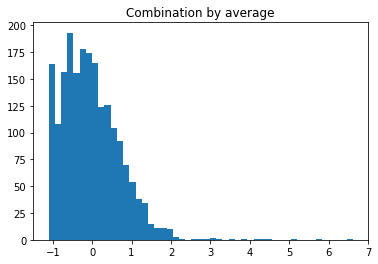

In [23]:
# Combination by average
# The test_scores_norm is 500 x 20. The "average" function will take the average of the 20 columns. The result "y_by_average" is a single column: 
y_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [24]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    1134
1     866
Name: y_by_average_cluster, dtype: int64

In [25]:
df_test.groupby('y_by_average_cluster').mean()

,is_elite_user,original_price,ship_cost,is_returned,returnRate,total_claim,unresolved_claim,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,review_rates_median,product_id,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,,,,,
0,0.256614,75.103638,4.745090,0.086420,0.103055,2.058527e+06,136.894180,36.035273,0.065255,0.002224,4.271020,1.082892,5.000000,4.878748,5.681736e+07,-0.529788
1,0.394919,120.301332,6.801615,0.187067,0.088291,4.059982e+05,462.929561,259.435335,0.383520,0.001664,3.794937,1.907621,4.515012,4.123557,5.745281e+07,0.649441


### Method 2: The Maximum of Maximum (MOM)

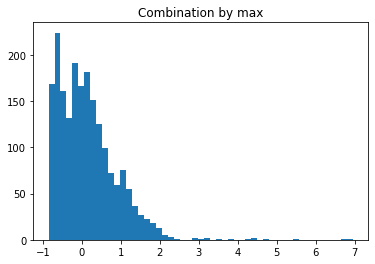

In [26]:
# Combination by mom
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [27]:
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<0, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

1    1028
0     972
Name: y_by_maximization_cluster, dtype: int64

In [28]:
df_test.groupby('y_by_maximization_cluster').mean()

,is_elite_user,original_price,ship_cost,is_returned,returnRate,total_claim,unresolved_claim,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,review_rates_median,product_id,y_by_average_score,y_by_average_cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,,,,,,,,,,
0,0.227366,73.003483,4.663892,0.065844,0.106841,2.236347e+06,115.869342,29.454733,0.046397,0.002318,4.272722,1.051440,5.00000,4.887860,5.644297e+07,-0.602624,0.000000,-0.432446
1,0.400778,115.164488,6.554307,0.190661,0.087038,4.982827e+05,431.429961,230.452335,0.351196,0.001663,3.868353,1.807393,4.59144,4.233949,5.770667e+07,0.532478,0.842412,0.690115


### Method 3: The Average of Maximum (AOM)

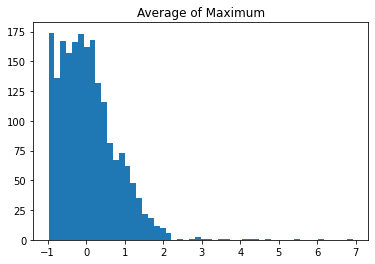

In [29]:
# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=5)
             
import matplotlib.pyplot as plt
plt.hist(y_by_aom, bins='auto')  # arguments are passed to np.histogram
plt.title("Average of Maximum")
plt.show()

In [30]:
df_test = pd.DataFrame(X_test)
df_test['y_by_aom_score'] = y_by_aom
df_test['y_by_aom_cluster'] = np.where(df_test['y_by_aom_score']<0, 0, 1)
df_test['y_by_aom_cluster'].value_counts()

0    1031
1     969
Name: y_by_aom_cluster, dtype: int64

In [31]:
df_test.groupby('y_by_aom_cluster').mean()

,is_elite_user,original_price,ship_cost,is_returned,returnRate,total_claim,unresolved_claim,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,review_rates_median,product_id,y_by_average_score,y_by_average_cluster,y_by_maximization_score,y_by_maximization_cluster,y_by_aom_score
y_by_aom_cluster,,,,,,,,,,,,,,,,,,,,
0,0.232784,73.427202,4.718625,0.065955,0.104740,2.143785e+06,123.292919,31.634336,0.054358,0.002267,4.266007,1.065955,5.000000,4.877304,5.670459e+07,-0.576577,0.000000,-0.404766,0.057226,-0.488564
1,0.405573,117.280736,6.611174,0.198142,0.088067,4.909413e+05,442.745098,240.371517,0.361285,0.001678,3.850876,1.837977,4.566563,4.205366,5.750526e+07,0.573877,0.893705,0.729014,1.000000,0.666705


### Method 4: The maximum of average (MOA)

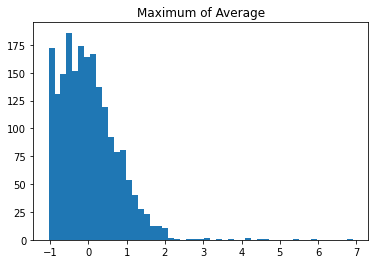

In [32]:
# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=5)

import matplotlib.pyplot as plt
plt.hist(y_by_moa, bins='auto')  # arguments are passed to np.histogram
plt.title("Maximum of Average")
plt.show()

In [33]:
df_test = pd.DataFrame(X_test)
df_test['y_by_moa_score'] = y_by_moa
df_test['y_by_moa_cluster'] = np.where(df_test['y_by_moa_score']<0, 0, 1)
df_test['y_by_moa_cluster'].value_counts()

0    1061
1     939
Name: y_by_moa_cluster, dtype: int64

In [34]:
df_test.groupby('y_by_moa_cluster').mean()

,is_elite_user,original_price,ship_cost,is_returned,returnRate,total_claim,unresolved_claim,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,...,review_rates_max,review_rates_median,product_id,y_by_average_score,y_by_average_cluster,y_by_maximization_score,y_by_maximization_cluster,y_by_aom_score,y_by_aom_cluster,y_by_moa_score
y_by_moa_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.237512,73.594181,4.740950,0.067861,0.104274,2.112497e+06,128.679548,33.606032,0.057918,0.002252,...,5.000000,4.877474,5.678636e+07,-0.562622,0.000000,-0.390339,0.083883,-0.474039,0.03016,-0.51278
1,0.405751,118.493135,6.646414,0.200213,0.088061,4.734881e+05,446.864750,244.812567,0.367068,0.001676,...,4.552716,4.183706,5.743845e+07,0.594865,0.922258,0.748935,1.000000,0.687203,0.99787,0.65094


In [35]:
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,
                                                   test_scores)

# Predicted scores from all base detectors on the test data is 
# stored in train_scores_norm and test_scores_norm
print('Decision score matrix on training data', train_scores_norm.shape)
print('Decision score matrix on test data', test_scores_norm.shape)

Decision score matrix on training data (8000, 20)
Decision score matrix on test data (2000, 20)


In [36]:
# Combine and evaluate the combination result

# Combination by average
y_by_average = average(test_scores_norm)
evaluate_print('Combination by Average', y_test, y_by_average)

# Combination by max
y_by_maximization = maximization(test_scores_norm)
evaluate_print('Combination by Maximization', y_test, y_by_maximization)

# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=5)
evaluate_print('Combination by AOM', y_test, y_by_aom)

# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=5)
evaluate_print('Combination by MOA', y_test, y_by_moa)

Combination by Average ROC:0.6884, precision @ rank n:0.2962
Combination by Maximization ROC:0.6846, precision @ rank n:0.2615
Combination by AOM ROC:0.6945, precision @ rank n:0.2731
Combination by MOA ROC:0.6943, precision @ rank n:0.2885


In [37]:
#####

In [38]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
samples = X_train[0:5]
samples

,is_elite_user,original_price,ship_cost,is_returned,returnRate,total_claim,unresolved_claim,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,review_rates_median,product_id
22391,0,199.95,4.700000,0.0,0.050737,46699,0,0,0.000000,0.000545,4.685714,1,5,5.0,81935947
52331,1,44.99,2.584682,1.0,0.127110,3269293,0,0,0.000000,0.002828,3.981818,1,5,5.0,80538890
66464,0,69.99,1.342857,1.0,0.127110,3269293,0,0,0.000000,0.002828,4.424893,1,5,5.0,58173095
71926,0,139.99,2.350000,0.0,0.127110,3269293,0,0,0.000000,0.002828,4.535662,1,5,5.0,32061791
49977,1,120.00,8.880000,0.0,0.102369,294,28,11,0.392857,0.003129,4.666667,4,5,5.0,67401234


### k-NN:

In [39]:
my_knn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(samples)
distances, indices = my_knn.kneighbors(samples, return_distance=True)
distances

array([[       0.        ,  3512389.55329624],
       [       0.        ,  3512389.55329624],
       [       0.        ,  9790041.05552147],
       [       0.        , 26111304.00009387],
       [       0.        ,  9790041.05552147]])

### k-means:

In [40]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(samples)
kmeans.labels_

array([0, 0, 0, 1, 0], dtype=int32)

In [41]:
centroids = kmeans.cluster_centers_
centroids

array([[5.00000000e-01, 1.08732500e+02, 4.37688472e+00, 5.00000000e-01,
        1.01831705e-01, 1.64639475e+06, 7.00000000e+00, 2.75000000e+00,
        9.82142857e-02, 2.33227449e-03, 4.43977296e+00, 1.75000000e+00,
        5.00000000e+00, 5.00000000e+00, 7.20122915e+07],
       [0.00000000e+00, 1.39990000e+02, 2.35000000e+00, 0.00000000e+00,
        1.27110098e-01, 3.26929300e+06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.82752715e-03, 4.53566230e+00, 1.00000000e+00,
        5.00000000e+00, 5.00000000e+00, 3.20617910e+07]])